<a href="https://colab.research.google.com/github/fredyah/mytorchscript/blob/main/4_Create_Model_Class_for_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [111]:
## Model Class
## fc1 的 in_features 值可參考 3_convolutional_Neural_Network.ipynb 最後的結果 torch.Size([1, 16, 5, 5])

class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

    ## Fully Connected Layer
    self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)

  def forward(self, X):
    ## First Pass
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(input=X, kernel_size=2, stride=2)

    ## Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(input=X, kernel_size=2, stride=2)

    ## Re-View to flatten it out
    X = X.view(-1, 16*5*5)  ## 調整 X shape ，使其符合 full connected in_features )

    ## Fully Connected Layers
    ## relu 是一種常用激活函數，全稱為修正線性單元。它的主要作用是將輸入值限制在一個非負的範圍內，即常輸入值小於0時，輸出值為0，當輸入值大於等於0時，輸出值等於輸入值本身。relu函數的表達式為：f(x)=max(0, x)
    ## 請注意，最後一個fc ，通常為輸出，不需要用的 relu

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return X


In [112]:
## Convert MNIST Image Files into a Tensor of 4-Dimensions ( of images, Height, Width, Color Channel )

transform = transforms.ToTensor()

## Train Data

train_data = datasets.MNIST('/cnn_data', train=True, download=True, transform=transform)

## Test Data

test_data = datasets.MNIST('/cnn_data', train=False, download=True, transform=transform)


## Create a small batch size for image
##  Batch size為批次的尺寸或稱作批次的大小，表示我們在讓機器學習資料集的知識時，一次是對多少筆資料做觀察整理的，然後對於這些資料的結論去做資料調整
'''
在使用 PyTorch 構建和訓練卷積神經網絡（CNN）時，shuffle 參數主要出現在數據加載器（DataLoader）中。它的作用是指示是否在每個 epoch 開始時將數據集的順序打亂。這對於提升模型的泛化能力非常重要。

為什麼需要 Shuffle？
打破數據集的順序依賴性：在許多數據集中，數據的排列順序可能具有某種模式或結構。如果模型總是按照固定的順序看到數據，可能會導致學習到無用的模式或過擬合特定的數據順序。
提高泛化能力：隨機打亂數據有助於模型更全面地學習數據分佈，從而提高對未見數據的泛化能力。
避免局部依賴性：通過打亂數據順序，可以確保每個小批量（batch）中的數據樣本是隨機的，減少局部依賴性，進一步提高訓練的穩定性。
'''

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)





In [113]:
## Create an Instance of our Model

torch.manual_seed(41) ## 讓結果可複現

model = ConvolutionalNetwork()
print(model)

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [114]:
## Loss Function Optimizer
'''
Cross Entropy Loss：
-------------------------
交叉熵損失（Cross-Entropy Loss）：這是一種常用的損失函數，特別適用於多類分類問題。它計算預測值與真實標籤之間的差異。具體來說，它衡量了模型輸出的概率分佈與真實標籤分佈之間的距離。
PyTorch 中的 nn.CrossEntropyLoss：這個函數自動將輸入的 logits 進行 softmax 變換，並計算最終的交叉熵損失。這意味著在使用這個損失函數時，你的模型輸出不需要顯式地應用 softmax 函數。


Adam：
-----------------
Adam 優化器：Adam（Adaptive Moment Estimation）是一種基於一階和二階矩估計自適應學習率的優化算法。它結合了 AdaGrad 和 RMSProp 的優點，在處理稀疏梯度和高噪聲問題上表現良好。Adam 是目前深度學習領域中最常用的優化算法之一。

lr
-----------------
這是學習率（Learning Rate），決定了每次更新參數時步伐的大小。較小的學習率會使訓練過程更穩定，但也會使訓練時間變長。選擇合適的學習率是模型訓練中的關鍵步驟。
常見的學習率範圍是 0.001 到 0.1。

'''

criterion = nn.CrossEntropyLoss()    ## 定義使用的標準
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)    ## 指定最佳化器 Smaller the Learning Rate, longer its gonna take to train.


In [115]:
start_time = time.time()

## Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

## For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  ## Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1  ## start our batches at 1
    y_pred = model(X_train)   ## get predicted values from the training set, Not flattened 2D
    loss = criterion(y_pred, y_train)  ## how off are we ? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1]  ## add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum()   ## how many we got correct from this batch. True = 1, False = 0, sum those up
    trn_corr += batch_corr  ## Keep track as we go along in training
    '''
    torch.max 用于返回给定张量中的最大值及其索引。具体来说：
    y_pred 是你的模型输出的预测结果张量。
    .data 获取张量的原始数据。
    torch.max(y_pred.data, 1) 将沿着指定维度（这里是第 1 维，即列）返回每行的最大值和索引。
    [1] 获取最大值所在的索引。
    通过这个代码，你可以得到模型预测的类别索引。
    '''

    ## Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%600 == 0:
      print(f"Epoch: {i} Batch: {b} Loss: {loss.item()}")



  train_losses.append(loss)
  train_correct.append(trn_corr)

  ## Test
  with torch.no_grad():  ## No gradient so we don't update our weights and biases with test data
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]   ## Adding up correct predictions
      tst_corr += (predicted == y_test).sum()    ## T=1 F=0 and sum away

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f"Training Took: {total/60} minutes !")

Epoch: 0 Batch: 600 Loss: 0.16236238181591034
Epoch: 0 Batch: 1200 Loss: 0.16415396332740784
Epoch: 0 Batch: 1800 Loss: 0.5098981261253357
Epoch: 0 Batch: 2400 Loss: 0.11590572446584702
Epoch: 0 Batch: 3000 Loss: 0.005982336588203907
Epoch: 0 Batch: 3600 Loss: 0.5348214507102966
Epoch: 0 Batch: 4200 Loss: 0.005393340718001127
Epoch: 0 Batch: 4800 Loss: 0.0014583868905901909
Epoch: 0 Batch: 5400 Loss: 0.03396736457943916
Epoch: 0 Batch: 6000 Loss: 0.00043186210677959025
Epoch: 1 Batch: 600 Loss: 0.002397039206698537
Epoch: 1 Batch: 1200 Loss: 0.341083824634552
Epoch: 1 Batch: 1800 Loss: 0.0012755367206409574
Epoch: 1 Batch: 2400 Loss: 0.0019284680020064116
Epoch: 1 Batch: 3000 Loss: 0.04880313202738762
Epoch: 1 Batch: 3600 Loss: 0.25365638732910156
Epoch: 1 Batch: 4200 Loss: 0.05716976523399353
Epoch: 1 Batch: 4800 Loss: 0.0002443505509290844
Epoch: 1 Batch: 5400 Loss: 0.00035591336200013757
Epoch: 1 Batch: 6000 Loss: 0.25528591871261597
Epoch: 2 Batch: 600 Loss: 0.11376402527093887
Epo

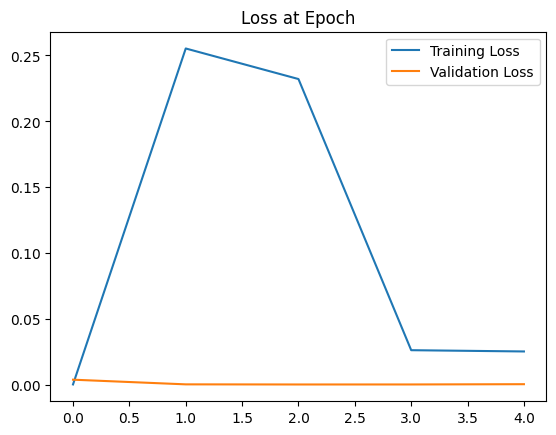

In [116]:
## Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss at Epoch')
plt.legend()


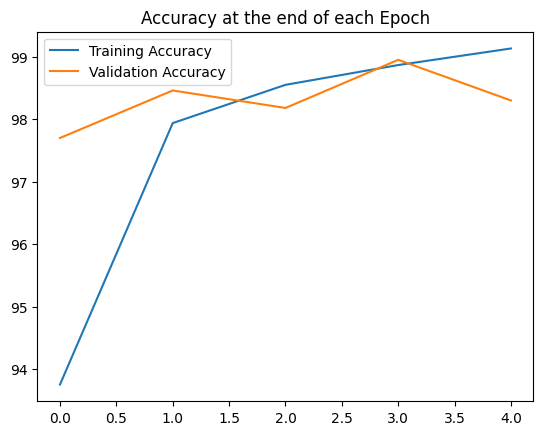

In [117]:
## Graph the accuracy at the end of each epoch

plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Validation Accuracy')
plt.title('Accuracy at the end of each Epoch')
plt.legend()

In [118]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)


In [119]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()


In [120]:
print(f"Correct Rate: {correct.item()/len(test_data)*100}%")

Correct Rate: 98.3%


4143


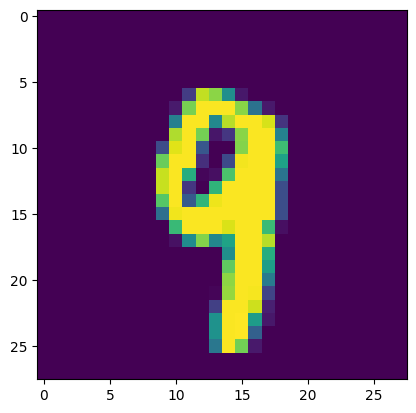

4148


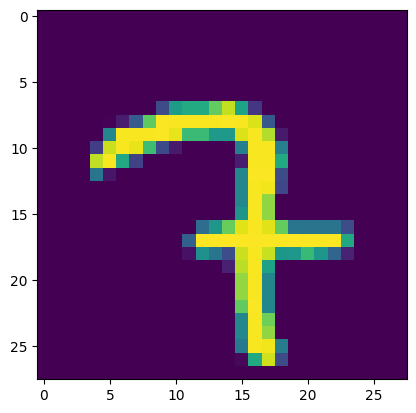

4433


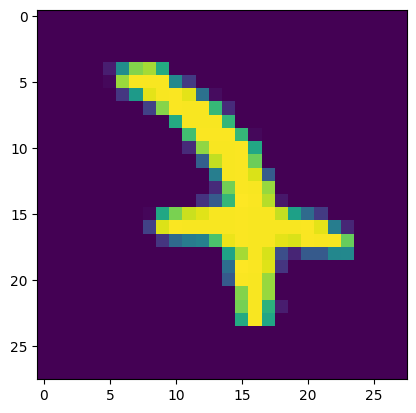

4455


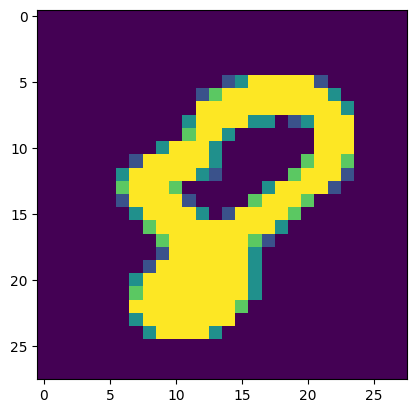

1978


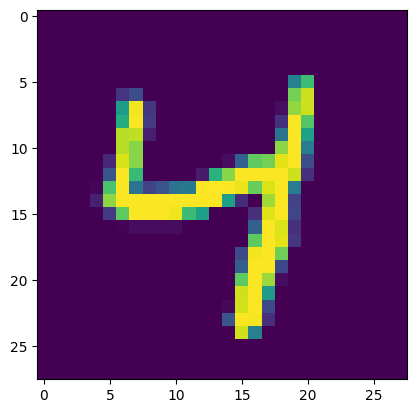

1987


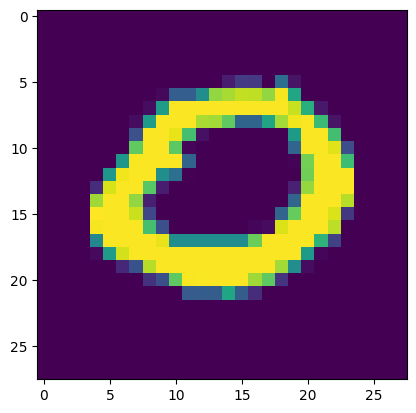

1900


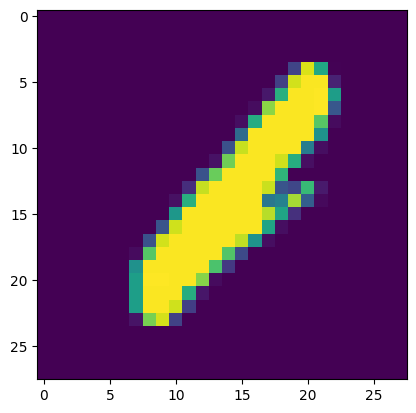

2024


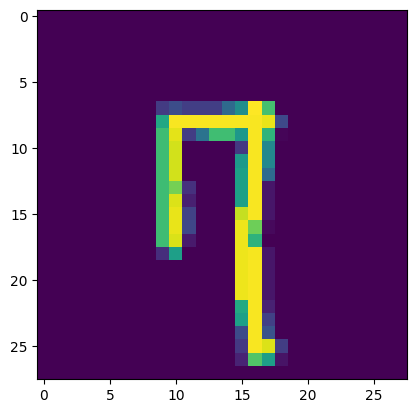

In [128]:
## Grab just the data
image_list = [4143, 4148, 4433, 4455, 1978, 1987, 1900, 2024]
for il in image_list:
  print(il)
  plt.imshow(test_data[il][0].reshape(28, 28))
  plt.show()

In [126]:
## Pass the image thru our model

for il in image_list:
  model.eval()
  with torch.no_grad():
    new_prediction = model(test_data[il][0].view(1, 1, 28, 28))   ## batch size of 1, 1 color channel, 28*28 image

    ## Check the new prediction , get probailities
    print(new_prediction)
    print(new_prediction.argmax())






tensor([[-12.0514,  -9.7295, -14.6479,  -5.2153,  -0.7024,  -8.4263, -20.9999,
          -4.6607,  -4.8068,   9.4609]])
tensor(9)
tensor([[-18.0999,  -7.5597,   0.2926,  -1.5685,  -8.1754, -15.0165, -26.0779,
           6.1369, -12.0350,  -9.1811]])
tensor(7)
tensor([[-26.9419,  -4.0111,  -3.2678,  -3.5585,  -8.1095, -17.0932, -26.2464,
           4.4501, -17.9498, -14.1027]])
tensor(7)
tensor([[ -9.0263, -10.7285, -15.3551, -11.1110,  -4.4665, -10.1182,  -9.8772,
         -11.8052,   6.6671,   2.8668]])
tensor(8)
tensor([[-14.1660,  -7.6472, -13.4594, -15.9929,  11.7601, -13.0939,  -6.2168,
          -9.6357,  -7.1396,  -2.5913]])
tensor(4)
tensor([[ -3.6032, -16.1125, -16.3100, -14.2161,  -3.2320,  -9.9212,  -9.6006,
          -9.3962,  -3.7749,   9.0454]])
tensor(9)
tensor([[ -7.6661,   4.6961,  -0.8615, -11.4966,  -2.8512, -10.4371,  -4.7784,
          -5.3006,  -6.8573, -11.6483]])
tensor(1)
tensor([[ -7.2234,  -3.7537,  -4.2401,  -4.7540,  -3.6891,  -5.3913, -14.5303,
           